# MVPC Pipeline — Running MVPC on Synthetic Data
This notebook loads the synthetic datasets generated in `01_generate_synthetic_data.ipynb` and runs the full MVPC pipeline:
- missingness‑parent detection  
- initial skeleton extraction  
- corrected skeleton search  
- orientation of the corrected skeleton  


In [2]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [3]:
%load_ext autoreload
%autoreload 2


In [8]:


import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mvpc.mvpc_pipeline import MVPC

# continuous CI tests
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw

# binary tests (kept for completeness, not used here)
from mvpc.ci_tests.bin_drw import bin_ci_drw
from mvpc.ci_tests.bin_permc import bin_ci_permc
from mvpc.ci_tests.bin_td import bin_ci_td  

from mvpc.missingness import detection_prt_m
from mvpc.skeleton import skeleton2




In [9]:
def plot_skeleton(G, title="Graph"):
    """
    Visualize a skeleton adjacency matrix using networkx.
    G should be a (p x p) numpy array of 0/1 entries.
    """
    p = G.shape[0]
    G_nx = nx.Graph()

    # add nodes
    for i in range(p):
        G_nx.add_node(i)

    # add edges
    for i in range(p):
        for j in range(i + 1, p):
            if G[i, j] == 1:
                G_nx.add_edge(i, j)

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G_nx, seed=42)
    nx.draw(
        G_nx,
        pos,
        with_labels=True,
        node_size=800,
        node_color="#87CEEB",
        font_size=12,
        width=2,
        edge_color="#555555"
    )
    plt.title(title)
    plt.show()


def plot_heatmap(G, title="Adjacency Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(G, cmap="Blues", square=True, cbar=False)
    plt.title(title)
    plt.show()


def evaluate_missingness_parents(true_prt, est_prt):
    """
    true_prt: dict {m_index: true_parent_index}
    est_prt: dict {m_index: [estimated_parent_indices]}
    """
    rows = []
    for m, true_parent in true_prt.items():
        est = est_prt.get(m, [])
        rows.append({
            "R_ind": m,
            "true_parent": true_parent,
            "estimated_parents": est,
            "correct": true_parent in est
        })
    return pd.DataFrame(rows)


def load_missingness_structure(path):
    """
    Load missingness structure CSV with columns:
    - m_ind
    - parent_m_ind
    Returns dict {m_ind: parent_m_ind}
    """
    gt = pd.read_csv(path)
    ms = gt["m_ind"].tolist()
    prt = gt["parent_m_ind"].tolist()
    return {m: p for m, p in zip(ms, prt)}


In [10]:
base_path = "../data/synthetic_data_csv_files/"

# Observed data with missingness
data_mar = pd.read_csv(base_path + "missing_mar.csv").values
data_mnar = pd.read_csv(base_path + "missing_mnar.csv").values

print("Shapes:")
print("MAR: ", data_mar.shape)
print("MNAR:", data_mnar.shape)

# Ground truth missingness structures
true_prt_mar = load_missingness_structure(base_path + "missingness_structure_mar.csv")
true_prt_mnar = load_missingness_structure(base_path + "missingness_structure_mnar.csv")

print("True missingness parents:")
print("MAR: ", true_prt_mar)
print("MNAR:", true_prt_mnar)


Shapes:
MAR:  (2000, 20)
MNAR: (2000, 20)
True missingness parents:
MAR:  {2: 8, 7: 4, 1: 15, 5: 0, 16: 13, 14: 11}
MNAR: {2: 8, 7: 4, 1: 15, 8: 10, 4: 16, 15: 5}


In [12]:
def run_mvpc_experiment(exp_name, data, indep_test, corr_test, true_prt):
    """
    Run MVPC for a given experiment and evaluate missingness parents.
    exp_name: string, e.g. "MAR‑PermC"
    """
    print(f"\n=== {exp_name} ===")

    mvpc = MVPC(
        indep_test=indep_test,
        corr_test=corr_test,
        alpha=0.05
    )
    res = mvpc.run(data)

    # print prt_m
    print("\nprt_m:")
    print("m:", res["prt_m"]["m"])
    print("prt:", res["prt_m"]["prt"])

    # evaluate missingness parents
    est_prt = res["prt_m"]["prt"]
    eval_df = evaluate_missingness_parents(true_prt, est_prt)
    print(f"\n{exp_name} — Missingness parent recovery:")
    display(eval_df)
    print(f"Accuracy: {eval_df['correct'].mean() * 100:.1f}%")

    # skeleton info
    G_corr = res["G_corrected"]
    print(f"\nCorrected skeleton shape: {G_corr.shape}")

    # visualize
    plot_heatmap(G_corr, title=f"{exp_name} — Corrected Skeleton (Heatmap)")
    # optional:
    # plot_skeleton(G_corr, title=f"{exp_name} — Corrected Skeleton (Graph)")

    return res, eval_df




=== MAR‑PermC ===
[Step 1] m_inds (vars with NaNs): [1, 2, 5, 7, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11), np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 94.12it/s]


[Step 1] R_ind=16, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 7, 14, 16]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value



prt_m:
m: [1, 2, 5, 7, 14, 16]
prt: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}

MAR‑PermC — Missingness parent recovery:


,R_ind,true_parent,estimated_parents,correct
0,2,8,[8],True
1,7,4,"[4, 11, 17]",True
2,1,15,[15],True
3,5,0,[0],True
4,16,13,[13],True
5,14,11,"[0, 11]",True


Accuracy: 100.0%

Corrected skeleton shape: (20, 20)


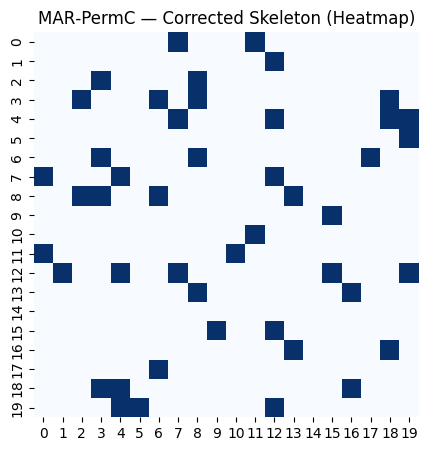


=== MNAR‑PermC ===
[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 8, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(16)]


[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 184.40it/s]


[Step 1] R_ind=15, parents=[np.int64(4), np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 7, 8, 15]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 4: [np.int64(16)], 7: [np.int64(4), np.int64(11)], 8: [np.int64(10)], 15: [np.int64(4), np.int64(5)]}


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value



prt_m:
m: [1, 2, 4, 7, 8, 15]
prt: {1: [np.int64(15)], 2: [np.int64(8)], 4: [np.int64(16)], 7: [np.int64(4), np.int64(11)], 8: [np.int64(10)], 15: [np.int64(4), np.int64(5)]}

MNAR‑PermC — Missingness parent recovery:


,R_ind,true_parent,estimated_parents,correct
0,2,8,[8],True
1,7,4,"[4, 11]",True
2,1,15,[15],True
3,8,10,[10],True
4,4,16,[16],True
5,15,5,"[4, 5]",True


Accuracy: 100.0%

Corrected skeleton shape: (20, 20)


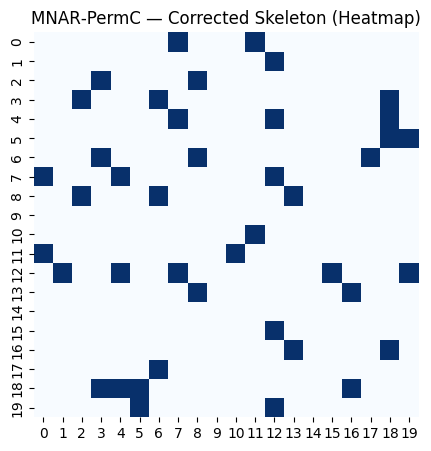


=== MAR‑DRW ===
[Step 1] m_inds (vars with NaNs): [1, 2, 5, 7, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11), np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 141.41it/s]


[Step 1] R_ind=16, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 7, 14, 16]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}



prt_m:
m: [1, 2, 5, 7, 14, 16]
prt: {1: [np.int64(15)], 2: [np.int64(8)], 5: [np.int64(0)], 7: [np.int64(4), np.int64(11), np.int64(17)], 14: [np.int64(0), np.int64(11)], 16: [np.int64(13)]}

MAR‑DRW — Missingness parent recovery:


,R_ind,true_parent,estimated_parents,correct
0,2,8,[8],True
1,7,4,"[4, 11, 17]",True
2,1,15,[15],True
3,5,0,[0],True
4,16,13,[13],True
5,14,11,"[0, 11]",True


Accuracy: 100.0%

Corrected skeleton shape: (20, 20)


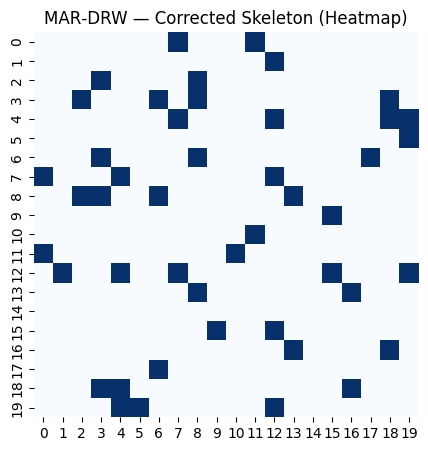


=== MNAR‑DRW ===
[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 8, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(16)]


[Step 1] R_ind=7, parents=[np.int64(4), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 186.10it/s]


[Step 1] R_ind=15, parents=[np.int64(4), np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 7, 8, 15]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(8)], 4: [np.int64(16)], 7: [np.int64(4), np.int64(11)], 8: [np.int64(10)], 15: [np.int64(4), np.int64(5)]}


ValueError: array must not contain infs or NaNs

In [13]:
results = {}
eval_tables = {}

# MAR‑PermC
res_mar_permc, eval_mar_permc = run_mvpc_experiment(
    exp_name="MAR‑PermC",
    data=data_mar,
    indep_test=gauss_ci_td,
    corr_test=gauss_ci_permc,
    true_prt=true_prt_mar
)
results["MAR‑PermC"] = res_mar_permc
eval_tables["MAR‑PermC"] = eval_mar_permc

# MNAR‑PermC
res_mnar_permc, eval_mnar_permc = run_mvpc_experiment(
    exp_name="MNAR‑PermC",
    data=data_mnar,
    indep_test=gauss_ci_td,
    corr_test=gauss_ci_permc,
    true_prt=true_prt_mnar
)
results["MNAR‑PermC"] = res_mnar_permc
eval_tables["MNAR‑PermC"] = eval_mnar_permc

# MAR‑DRW
res_mar_drw, eval_mar_drw = run_mvpc_experiment(
    exp_name="MAR‑DRW",
    data=data_mar,
    indep_test=gauss_ci_td,
    corr_test=gauss_ci_drw,
    true_prt=true_prt_mar
)
results["MAR‑DRW"] = res_mar_drw
eval_tables["MAR‑DRW"] = eval_mar_drw

# MNAR‑DRW
res_mnar_drw, eval_mnar_drw = run_mvpc_experiment(
    exp_name="MNAR‑DRW",
    data=data_mnar,
    indep_test=gauss_ci_td,
    corr_test=gauss_ci_drw,
    true_prt=true_prt_mnar
)
results["MNAR‑DRW"] = res_mnar_drw
eval_tables["MNAR‑DRW"] = eval_mnar_drw
